In [25]:
import warnings
warnings.filterwarnings('ignore')

# Основные
import numpy as np 
import pandas as pd
from ydata_profiling import ProfileReport
import sqlite3
from sqlalchemy import create_engine

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import nltk
from wordcloud import WordCloud
import nbformat

# Статистика
from scipy import stats
from scipy.stats import norm

%matplotlib inline

In [2]:
df = pd.read_csv('ds_salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [3]:
df.shape

(3755, 11)

In [4]:
# Просмотр типа данных
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [5]:
# Проверка на пустые значения
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [6]:
#Проверка на дубликаты
duplicate_rows_data = df[df.duplicated()]
print(duplicate_rows_data.shape)

(1171, 11)


In [7]:
df = df.drop_duplicates()
df.shape

(2584, 11)

In [8]:
# Проверка уникальных значений
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} уникальных значений")

work_year: 4 уникальных значений
experience_level: 4 уникальных значений
employment_type: 4 уникальных значений
job_title: 93 уникальных значений
salary: 815 уникальных значений
salary_currency: 20 уникальных значений
salary_in_usd: 1035 уникальных значений
employee_residence: 78 уникальных значений
remote_ratio: 3 уникальных значений
company_location: 72 уникальных значений
company_size: 3 уникальных значений


In [9]:
# Наименование столбцов соответствует naming convention.
# Уточнение наименования значений данных.
df['experience_level'] = df['experience_level'].replace({
    'EN': 'Junior',
    'MI': 'Middle',
    'SE': 'Senior',
    'EX': 'Executive',
})

df['employment_type'] = df['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})

df['company_size'] = df['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
df['remote_ratio'] = df['remote_ratio'].astype(str)
df['remote_ratio'] = df['remote_ratio'].replace({
    '0': 'Office',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

In [10]:
df.job_title.unique()


array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

In [11]:
#Группировка профессий и удаление лишних колонок
def assign_broader_category(job_title):
    data_analyst = [
       'Data Analyst',
       'Data Quality Analyst',
       'Compliance Data Analyst',
       'Business Data Analyst',
       'Staff Data Analyst',
       'Financial Data Analyst',
       'BI Analyst',
       'Data Analytics Specialist',
       'BI Data Analyst',
       'Insight Analyst',
       'Product Data Analyst',
       'Data Analytics Consultant',
       'Data Operations Analyst',
       'Marketing Data Analyst',
       'Principal Data Analyst',
       'Finance Data Analyst'
       'Lead Data Analyst',
       'Data Analytics Lead'
    ]
    data_engineering = [
        'Analytics Engineer',
        'Research Engineer',
        'Business Intelligence Engineer',
        'Data Engineer',
        'Applied Machine Learning Engineer',
        'ETL Engineer',
        'Big Data Engineer',
        'BI Data Engineer',
        'Cloud Database Engineer',
        'Data Infrastructure Engineer',
        'Software Data Engineer',
        'Data Operations Engineer',
        'Deep Learning Engineer',
        'Azure Data Engineer',
        'Marketing Data Engineer',
        'Data Science Engineer',
        'Data Analytics Engineer',
        'Cloud Data Engineer',
        'Principal Data Engineer',
        'Lead Data Engineer'
        ]
    
    data_scientist = [
        'Principal Data Scientist',
        'Data Scientist',
        'Applied Scientist',
        'Research Scientist',
        'Applied Data Scientist',
        'Deep Learning Researcher',
        'Data Science Consultant',
        'Product Data Scientist',
        'Staff Data Scientist',
        'Lead Data Scientist',
        'Data Scientist Lead',
        'Data Science Tech Lead',
        'Data Science Lead'        
    ]
        
    machine_learning = [
        'ML Engineer',
        'Machine Learning Engineer',
        'Machine Learning Researcher',
        'Machine Learning Scientist',
        'MLOps Engineer',
        'Applied Machine Learning Scientist',
        'Machine Learning Infrastructure Engineer',
        'Machine Learning Software Engineer',
        'Machine Learning Research Engineer',
        'Machine Learning Developer',
        'Principal Machine Learning Engineer',
        'Lead Machine Learning Engineer'
    ]
    
    data_architecture = [
        'Data Architect',
        'Big Data Architect',
        'Principal Data Architect',
        'Cloud Data Architect'
    ]
    
    management = [
        'Data Analytics Manager',
        'Head of Data',
        'Data Science Manager',
        'Data Manager',
        'Director of Data Science',
        'Head of Data Science',
        'Data Lead',
        'Manager Data Management',
        'Data Management Specialist',
        'Machine Learning Manager',
        'Head of Machine Learning'
    ]
    
    if job_title in data_analyst:
        return "Data Analyst"
    elif job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

df['job_category'] = df['job_title'].apply(assign_broader_category)
df.insert(loc=0, column='id', value=(np.arange(1, 1 + len(df))))
df.drop(df[['salary','salary_currency']], axis = 1, inplace = True)

In [13]:
df.shape

(2584, 11)

In [14]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Загрзука в БД SQLite
database_path = r'C:\sqlite\ds_salary'
engine = create_engine(f'sqlite:///{database_path}')
connection = engine.connect()
table_name = 'ds_salary'
df.to_sql(table_name, engine, if_exists='replace', index=False)

2584

In [16]:
# Закрываем соединение
connection.close()

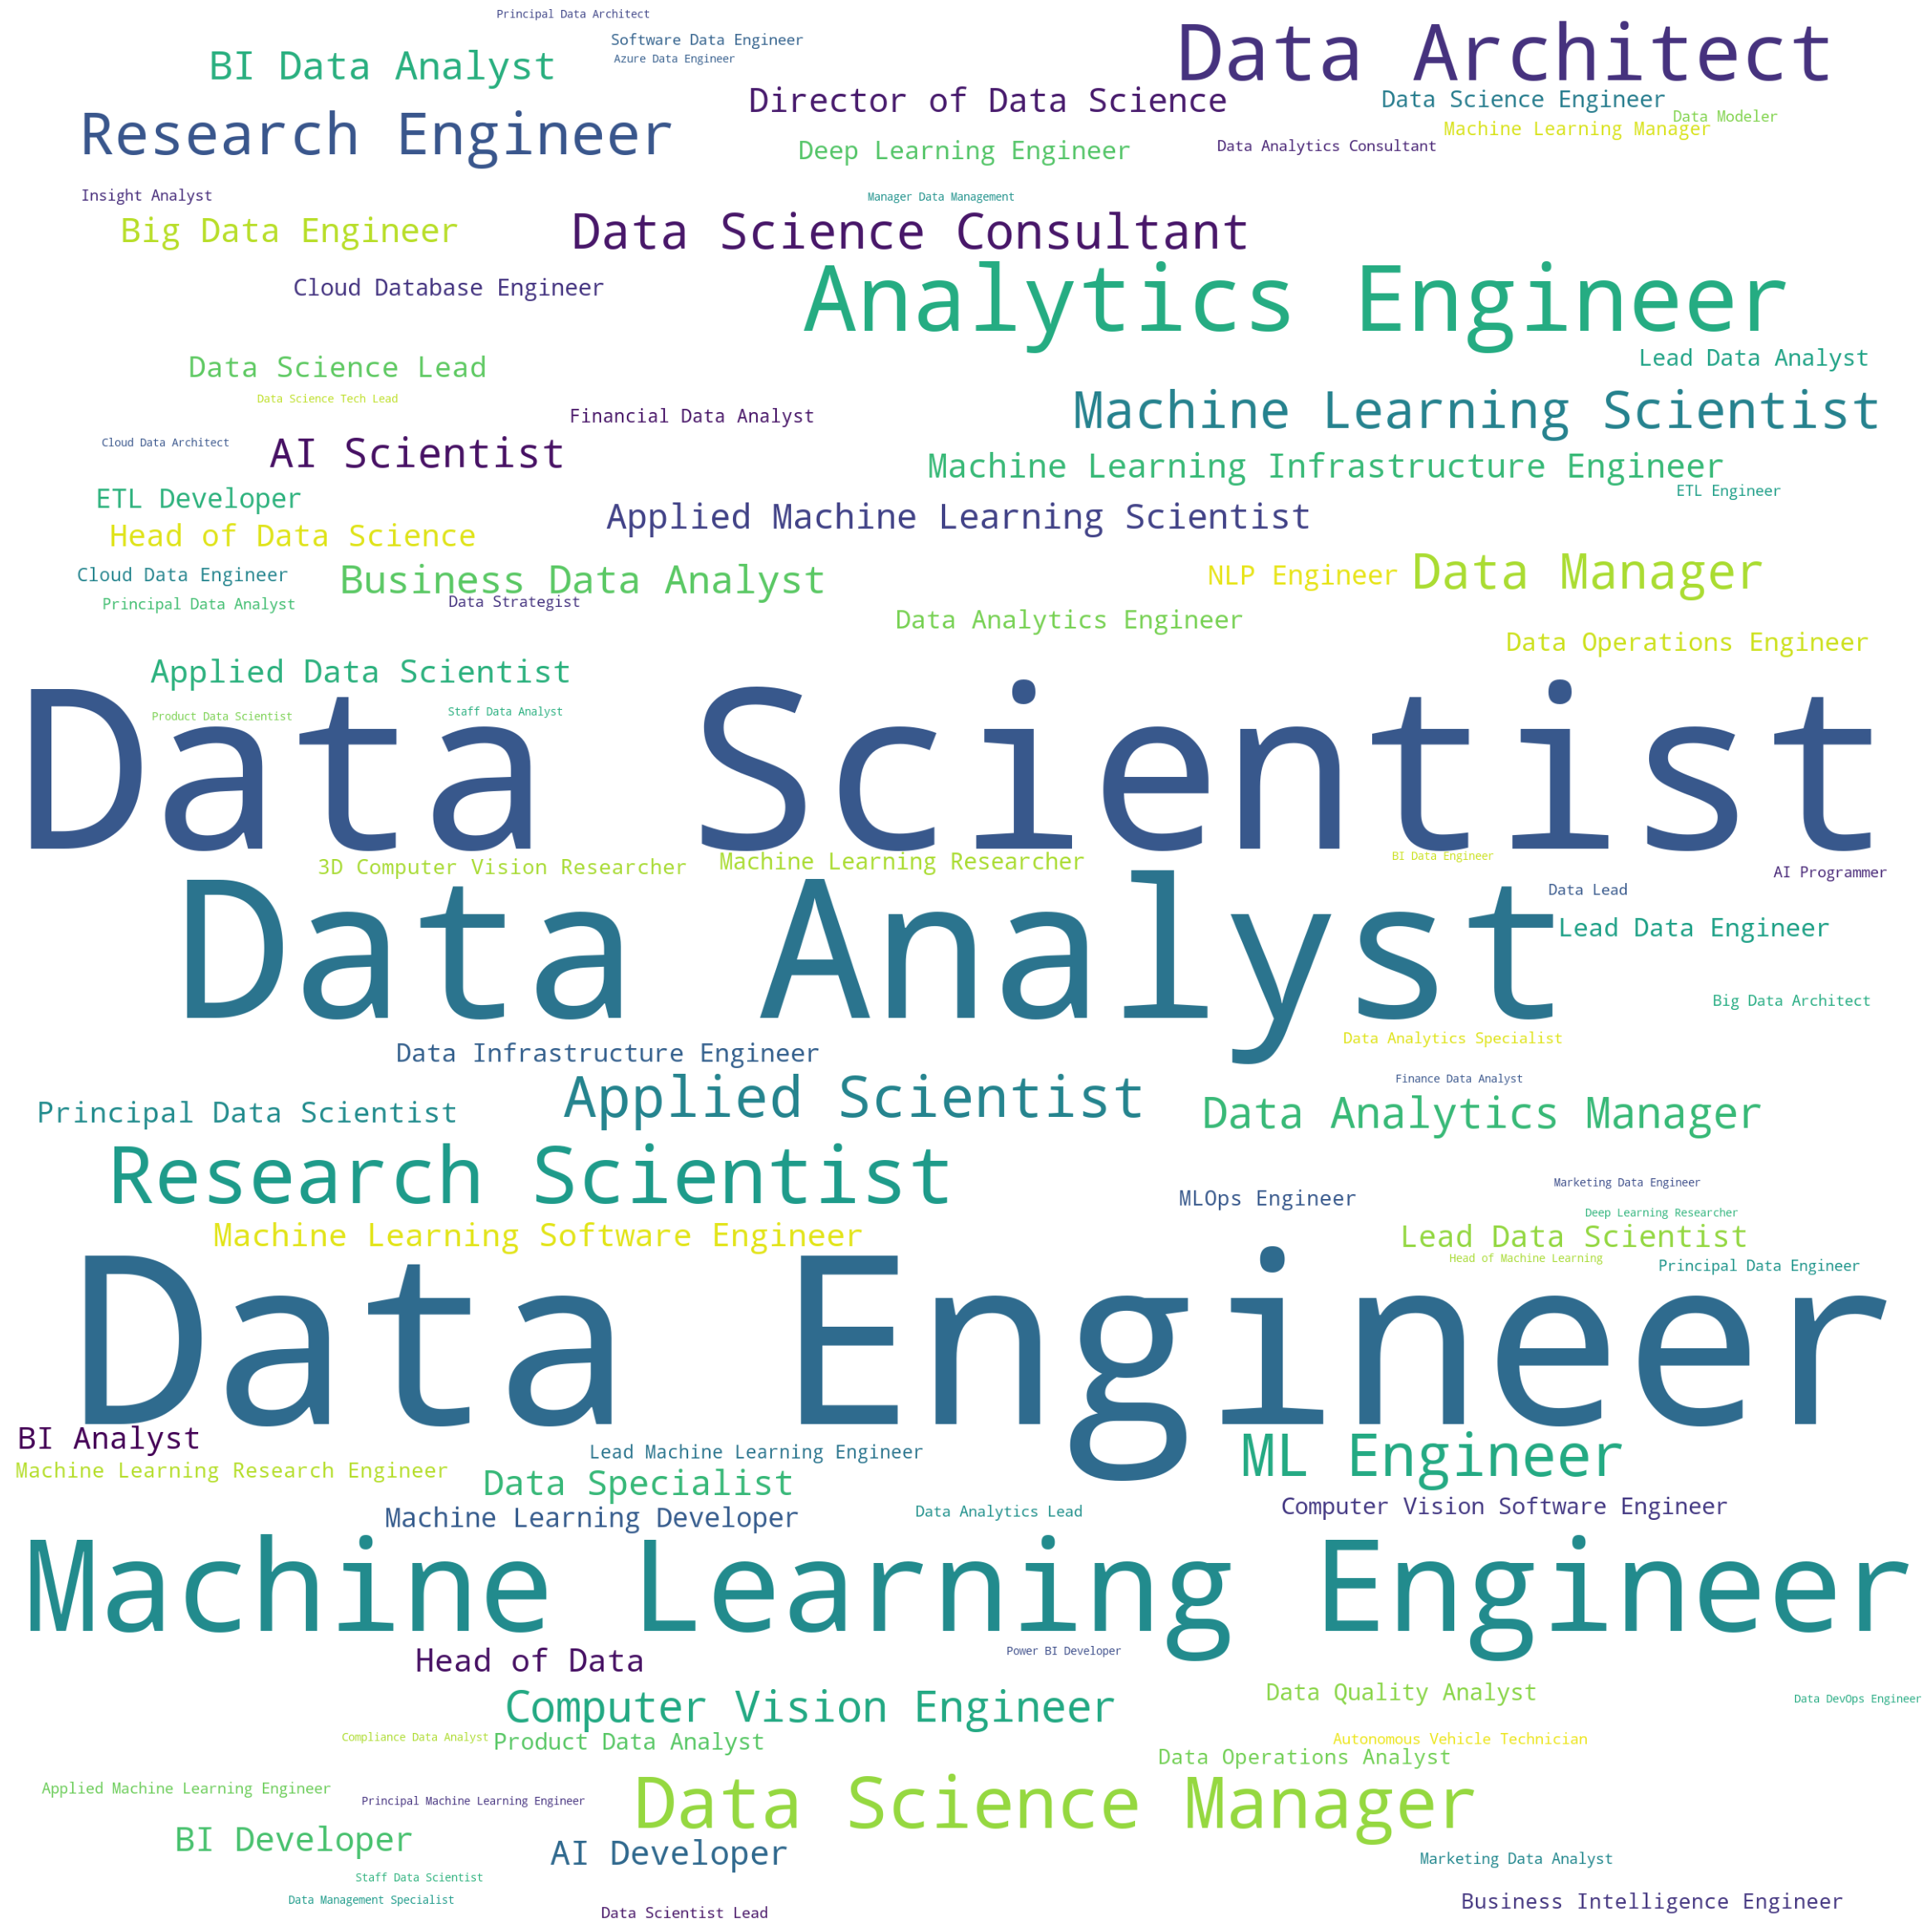

In [18]:
#WordCloud

def Freq_df(word_list):
    Freq_dist_nltk = nltk.FreqDist(word_list)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient = 'index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by = ['Frequency'], ascending = False)
    df_freq = df_freq.reset_index()
    return df_freq

def Word_Cloud(data, title):
    plt.figure(figsize = (40,30))
    wc = WordCloud(
        width = 2400, 
        height = 2400, 
        #max_words = 100,
        background_color = 'white',
        #min_font_size = 30,
        #max_font_size = 100
        prefer_horizontal = 1.5
        )
    wc.generate_from_frequencies(data)
    
    plt.imshow(wc)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
freq_df = Freq_df(df['job_title'].values.tolist())
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

Word_Cloud(data , '')

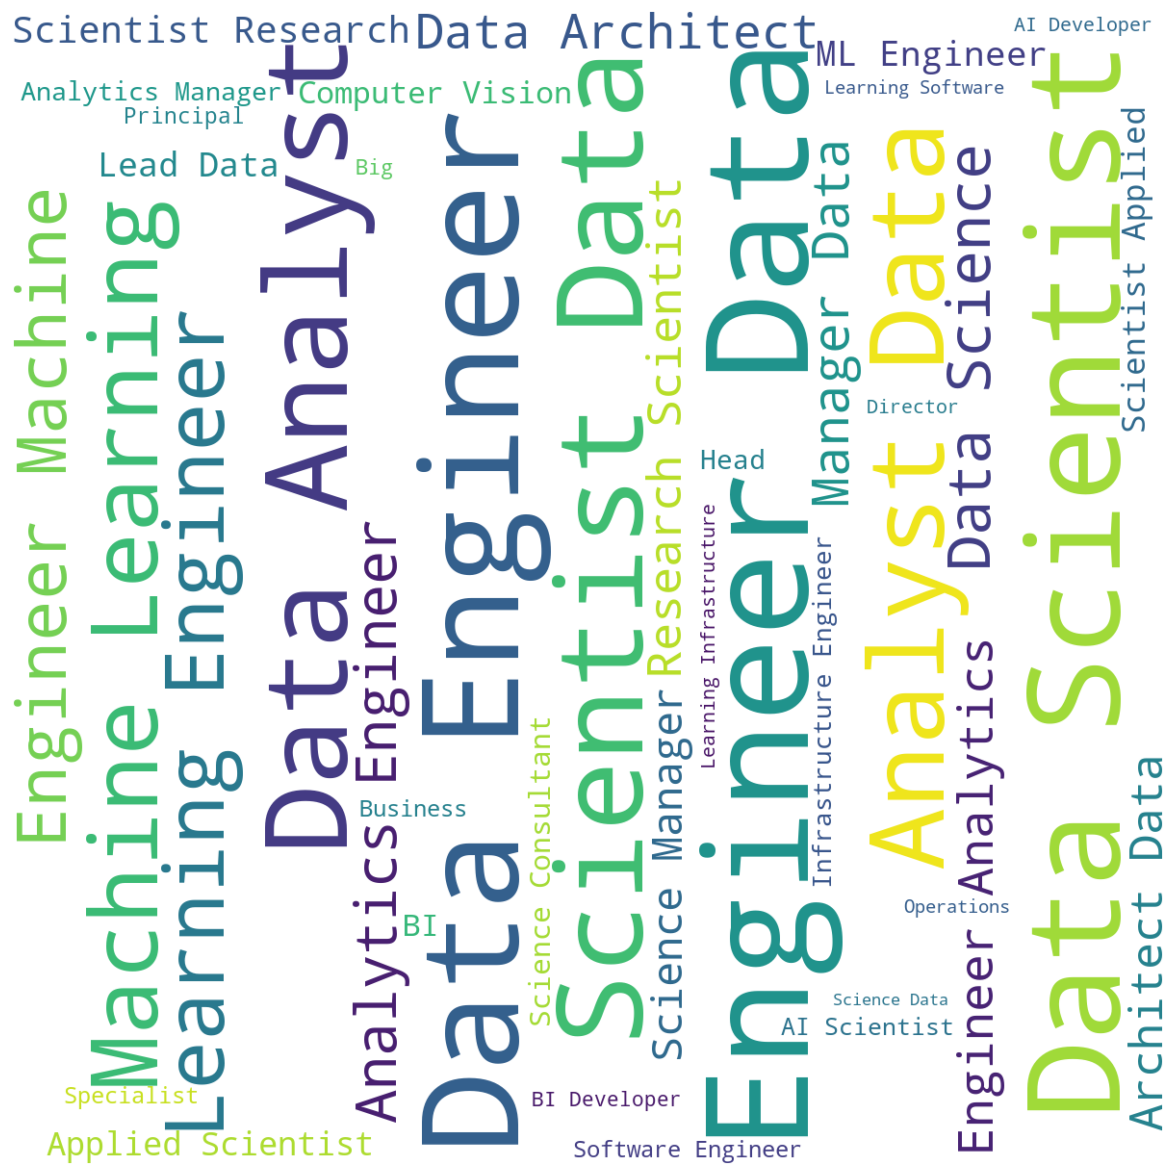

In [19]:
#Упрощенный WordCloud

dic = dict(df.job_title)
text = ' '.join(dic.values()) 
wordcloud = WordCloud(
    background_color="white",
    width = 1200, 
    height = 1200,
    min_font_size = 17,
    #max_words = 100,
    ).generate(text)
plt.figure(figsize = (20,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
ex_level = df['experience_level'].value_counts()
fig = px.treemap(ex_level, path = [ex_level.index], values = ex_level.values, 
                title = 'Experience Level')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed